In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# SQL
import sqlite3

# Data Selection

In [2]:
def sql_preprocess(cursor, table, columns):
    # Select the columns
    cursor.execute(f'''
        CREATE TEMP TABLE filtered_col AS
        SELECT {", ".join(columns)} FROM {table}
    ''')

    # Identify numeric columns
    cursor.execute(f'PRAGMA table_info(filtered_col)')
    columns_info = cursor.fetchall()
    numeric_cols = [col[1] for col in columns_info if col[2] in ('INTEGER', 'REAL')]

    # Null condition
    null_condition = ' AND '.join(f'{col} IS NOT NULL' for col in numeric_cols)
    cursor.execute(f'''
        CREATE TEMP TABLE filtered_null AS
        SELECT * FROM filtered_col
        WHERE {null_condition}
    ''')

    # Group by day
    cursor.execute(f'''
        CREATE TEMP TABLE filtered_day AS
        SELECT 
            COUNT(*) AS row_count,
            DATE(utc_timestamp) AS utc_day,
            {', '.join([f'AVG({col}) AS {col[3:]}_avg' for col in numeric_cols])}
        FROM filtered_null
        GROUP BY utc_day
    ''') # DATE(SUBSTR(cet_cest_timestamp, 1, 19)) AS cet_day

    return 'filtered_day'

def sql_reader(db_path, table):
    conn = sqlite3.connect(db_path) # Connect to the SQLite database
    cursor = conn.cursor() # Declare a cursor

    # Get the columns matching the pattern
    cursor.execute(f"""
        SELECT name
        FROM pragma_table_info('{table}')
        WHERE name LIKE '%timestamp%' OR name LIKE 'BE%'               
    """)
    columns = [row[0] for row in cursor.fetchall()]

    # Preprocess
    filtered_table = sql_preprocess(cursor, table, columns)
    df = pd.read_sql_query(f"SELECT * FROM {filtered_table}", conn, parse_dates=['utc_day'])

    conn.commit()
    conn.close()

    return df

In [3]:
df_cons = sql_reader('../DB/time_series.sqlite', 'time_series_60min_singleindex')
df_weather = sql_reader('../DB/weather_data.sqlite', 'weather_data')

In [4]:
db_path = '../DB/energy_weather.sqlite' # Create the database
conn = sqlite3.connect(db_path) # Connect to the SQLite database
# Create tables from dataframes
df_cons.to_sql('consumption', conn, if_exists='replace', index=False)
df_weather.to_sql('weather', conn, if_exists='replace', index=False)
# Create joined table based on utc_day
cons_select = [f'c.{col}' for col in df_cons.columns if col != 'utc_day']
weather_select = [f'w.{col}' for col in df_weather.columns if col not in df_cons.columns]
select_clause = ", ".join(cons_select + weather_select)
conn.execute("DROP TABLE IF EXISTS joined_data")
join_query = f"""
    CREATE TABLE joined_data AS
    SELECT 
        c.utc_day,
        {select_clause}
    FROM consumption c
    INNER JOIN weather w ON c.utc_day = w.utc_day
""" # STRFTIME('%Y', c.utc_day) AS year, STRFTIME('%m', c.utc_day) AS month, STRFTIME('%w', c.utc_day) AS day_of_week,
conn.execute(join_query)
df_joined = pd.read_sql_query(f"SELECT * FROM joined_data", conn, parse_dates=['utc_day'])
conn.commit()
conn.close()
df_joined.head(5)

,utc_day,row_count,load_actual_entsoe_transparency_avg,load_forecast_entsoe_transparency_avg,solar_generation_actual_avg,wind_generation_actual_avg,wind_offshore_generation_actual_avg,wind_onshore_generation_actual_avg,temperature_avg,radiation_direct_horizontal_avg,radiation_diffuse_horizontal_avg
0,2015-01-01,16,9302.750000,10128.375000,239.304375,1327.441250,640.738750,686.702500,0.478875,16.781469,24.558072
1,2015-01-02,24,9977.791667,9964.000000,88.245000,1230.979167,614.502500,616.476667,3.592583,6.822604,24.647204
2,2015-01-03,24,10167.041667,10112.666667,11.927500,528.915833,285.200833,243.715000,1.103125,0.307500,12.280505
3,2015-01-04,24,9925.166667,9559.083333,152.966250,220.054583,92.094583,127.960000,0.753250,27.074776,21.287341
4,2015-01-05,24,11618.875000,10904.708333,131.757083,327.642083,142.565417,185.076667,-0.065750,2.537711,24.178427


# Data Preprocessing

In [5]:
df = df_joined.copy()
# df['year'] = df['utc_day'].dt.year
# df['month'] = df['utc_day'].dt.month
df['day_of_week'] = df['utc_day'].dt.dayofweek

target = 'load_actual_entsoe_transparency_avg'
features = [c for c in df.select_dtypes(include=[np.number]).columns.tolist() if c != target]
features.remove('load_forecast_entsoe_transparency_avg')

X = df[features].copy()
y = df[target].copy()

# Time-series dataset --> Chronological split (avoid breaking the temporal order):
# Training data comes from earlier time periods, while test data comes from later time periods
split_index = int(len(X) * 0.8) # test_size = 0.2
# Avoid data leakage from future to past
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

def outlier_filter(df_in, iqr_multiplier=1.5): # Using IQR per-feature
    lower = df_in.quantile(0.25)
    upper = df_in.quantile(0.75)
    iqr = upper - lower
    lo = lower - iqr_multiplier * iqr
    hi = upper + iqr_multiplier * iqr
    mask = df_in.apply(lambda col: (col >= lo[col.name]) & (col <= hi[col.name]))
    # Count the number of False elements per column in the mask
    print("Outlier counts per column:")
    print((~mask).sum())
    keep = mask.all(axis=1) # Keep rows where all numeric columns are within bounds
    return keep, lo, hi

keep_train, lo_bounds, hi_bounds = outlier_filter(X_train)
X_train_clean = X_train.loc[keep_train].copy()
y_train_clean = y_train.loc[keep_train].copy()
# Apply same bounds to test
mask_test = X_test.apply(lambda col: (col >= lo_bounds[col.name]) & (col <= hi_bounds[col.name]))
keep_test = mask_test.all(axis=1)
X_test_clean = X_test.loc[keep_test].copy()
y_test_clean = y_test.loc[keep_test].copy()

def corr_filter(X_in, corr_tresh=0.9):
    corr_matrix = X_in.corr().abs()
    upper_triangular = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [col for col in upper_triangular.columns if any(upper_triangular[col] > corr_tresh)]
    return to_drop

# Variance filter independent from the original units
def variance_filter(X_in, cv_tresh=0.01):
    means = X_in.mean().abs()
    stds = X_in.std()
    cv = stds / means.replace(0, np.nan) # coefficient of variation
    to_drop = cv[cv <= cv_tresh].index.tolist()
    return to_drop

cols_to_drop = corr_filter(X_train_clean) + variance_filter(X_train_clean, cv_tresh=0)
X_train_final = X_train_clean.drop(columns=cols_to_drop)
X_test_final = X_test_clean.drop(columns=cols_to_drop)

date = df['utc_day'].copy()

Outlier counts per column:
row_count                              351
solar_generation_actual_avg              0
wind_generation_actual_avg              11
wind_offshore_generation_actual_avg      9
wind_onshore_generation_actual_avg      47
temperature_avg                          0
radiation_direct_horizontal_avg          0
radiation_diffuse_horizontal_avg         0
day_of_week                              0
dtype: int64


# Time Series Decomposition (Trend - Seasonality - Residual)

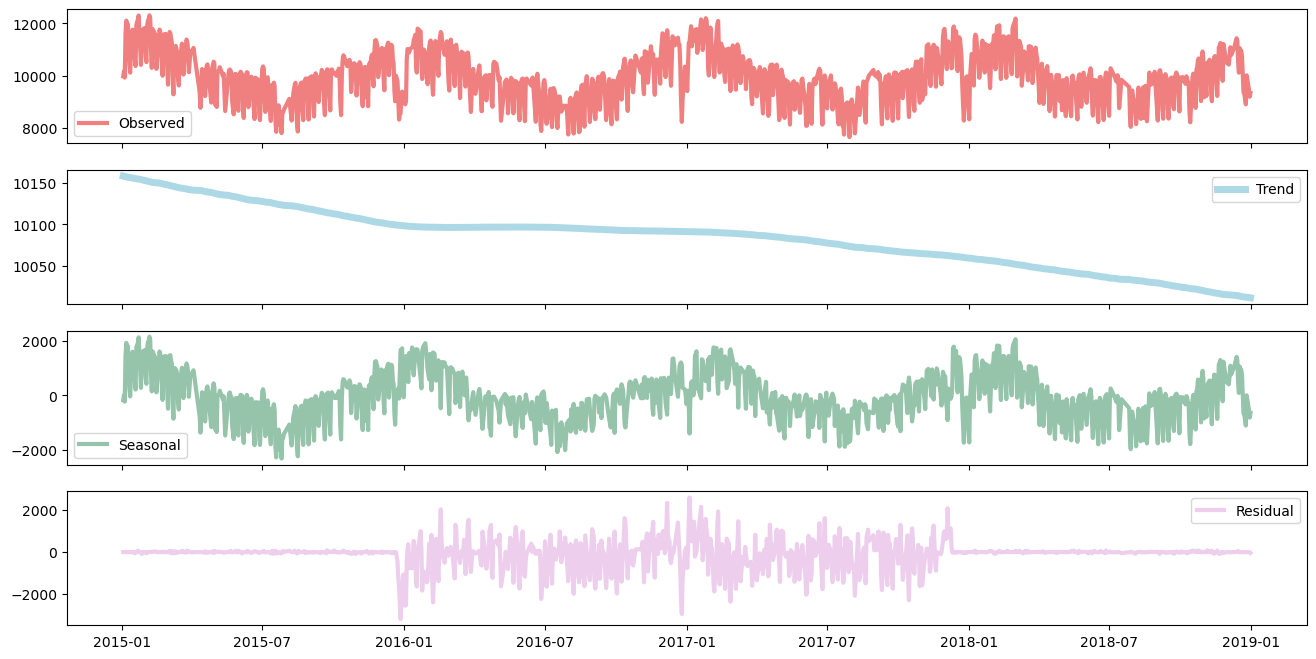

In [187]:
from statsmodels.tsa.seasonal import seasonal_decompose, STL # Seasonal and Trend Decomposition using Loess

X_train = X_train_final
X_test = X_test_final
y_train = y_train_clean
y_test = y_test_clean

stl = STL(y_train, period=270, robust=True) # Warning !!! Because of preprocessing, we don't have 365 points per year !!!
ts_decompos = stl.fit()
# ts_decompos = seasonal_decompose(y_train, model='additive', period=365)

def decomposition_evolution(date, decomposition):
    fig, ax = plt.subplots(4, 1, figsize=(16, 8), sharex=True)

    ax[0].plot(date, decomposition.observed, color='lightcoral', linewidth=3)
    ax[0].legend(['Observed'])
    ax[1].plot(date, decomposition.trend, color='lightblue', linewidth=5)
    ax[1].legend(['Trend'])
    ax[2].plot(date, decomposition.seasonal, color='seagreen', linewidth=3, alpha=0.5)
    ax[2].legend(['Seasonal'])
    ax[3].plot(date, decomposition.resid, color='plum', linewidth=3, alpha=0.5)
    ax[3].legend(['Residual'])

    plt.show()

decomposition_evolution(date[y_train.index], ts_decompos)

annual_trend = pd.DataFrame({'year': date[y_train.index].dt.year, 'consumption': ts_decompos.trend})
annual_trend_agg = annual_trend.groupby('year', as_index=False).sum()

In [186]:
y_train

1        9977.791667
2       10167.041667
3        9925.166667
4       11618.875000
5       12100.000000
            ...     
1453     8902.333333
1454    10010.666667
1457     9481.166667
1458     9193.750000
1459     9332.041667
Name: load_actual_entsoe_transparency_avg, Length: 1060, dtype: float64

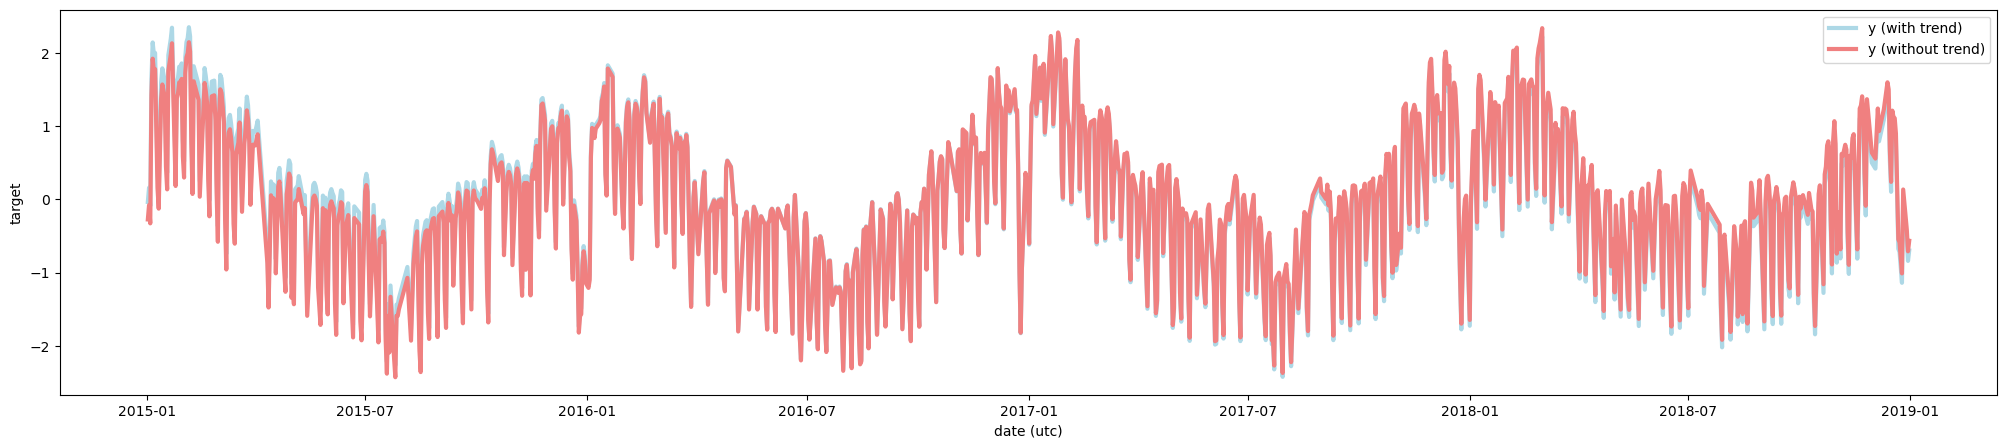

In [178]:
from sklearn.preprocessing import StandardScaler

def line_comparison(date, y, y_rem):
    plt.figure(figsize=(25,5))
    plt.plot(date, y, label='y (with trend)', linewidth=3, color='lightblue')
    plt.plot(date, y_rem, label='y (without trend)', linewidth=3, color='lightcoral')
    plt.xlabel('date (utc)')
    plt.ylabel('target')
    plt.legend()
    plt.show()

y_train_rem = y_train - ts_decompos.trend

scaler = StandardScaler()
# StandardScaler expects 2D input: reshape the Series to (-1, 1), then flatten back for plotting
y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_train_rem_scaled = scaler.fit_transform(y_train_rem.values.reshape(-1, 1)).ravel()

line_comparison(date[y_train.index], y_train_scaled, y_train_rem_scaled)

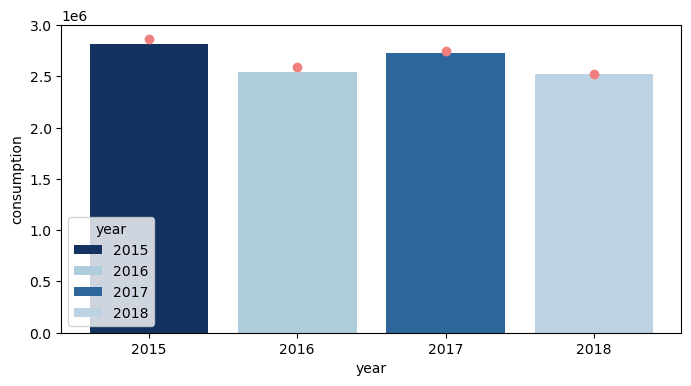

In [179]:
# Plot the annual consumption with barplot
# Aggregate daily loads to annual totals then plot
annual = pd.DataFrame({'year': date[y_train.index].dt.year, 'consumption': y_train})
annual_agg = annual.groupby('year', as_index=False).sum()

annual_trend = pd.DataFrame({'year': date[ts_decompos.trend.index].dt.year, 'consumption': ts_decompos.trend})
annual_trend_agg = annual_trend.groupby('year', as_index=False).sum()

norm = plt.Normalize(0.95*annual_agg['consumption'].min(), annual_agg['consumption'].max())
cmap = plt.get_cmap("Blues")
colors = [cmap(norm(value)) for value in annual_agg['consumption']]

fig, ax = plt.subplots(figsize=(8,4))
sns.barplot(data=annual_agg, x='year', y='consumption', hue='year', palette=colors, ax=ax)
x_pos = np.arange(len(annual_trend_agg))
ax.scatter(x_pos, annual_trend_agg['consumption'], color='lightcoral')
plt.show()